In [18]:
import pandas as pd

In [19]:
pd.set_option('display.max_columns', None)

# COVID-19

In [21]:
data = pd.read_csv('latest_raw.csv', error_bad_lines=False)

b'Skipping line 92377: expected 41 fields, saw 78\nSkipping line 93496: expected 41 fields, saw 78\nSkipping line 93556: expected 41 fields, saw 78\nSkipping line 94294: expected 41 fields, saw 78\nSkipping line 95527: expected 41 fields, saw 78\nSkipping line 98127: expected 41 fields, saw 78\n'
b'Skipping line 98766: expected 41 fields, saw 78\nSkipping line 102303: expected 41 fields, saw 78\nSkipping line 102816: expected 41 fields, saw 78\nSkipping line 107193: expected 41 fields, saw 78\nSkipping line 107358: expected 41 fields, saw 78\nSkipping line 107596: expected 41 fields, saw 78\nSkipping line 107762: expected 41 fields, saw 78\nSkipping line 113077: expected 41 fields, saw 78\n'
b'Skipping line 119025: expected 41 fields, saw 78\nSkipping line 120759: expected 41 fields, saw 78\nSkipping line 121322: expected 41 fields, saw 78\nSkipping line 123278: expected 41 fields, saw 78\nSkipping line 124366: expected 41 fields, saw 78\nSkipping line 127156: expected 41 fields, saw 1

In [22]:
data.ENTIDAD.unique()

array(['Sinaloa', 'Jalisco', 'Chihuahua', 'Ciudad de Mexico',
       'Nuevo Leon', 'Morelos', 'Tabasco', 'Mexico', 'Coahuila', 'Sonora',
       'San Luis Potosi', 'Tamaulipas', 'Guanajuato', 'Quintana Roo',
       'Yucatan', 'Baja California', 'Puebla', 'Zacatecas', 'Hidalgo',
       'Baja California Sur', 'Michoacan', 'Veracruz', 'Aguascalientes',
       'Durango', 'Guerrero', 'Oaxaca', 'Tlaxcala', 'Nayarit', 'Chiapas',
       'Queretaro', 'Colima', 'Campeche'], dtype=object)

In [23]:
#data.isnull().head(), data.isnull().tail()

In [24]:
data.isnull().values.any()

True

In [25]:
data.isnull().values.sum()

5701

In [26]:
# null_data = data[data.isnull().any(axis=1)] # missing city of residente

In [27]:
# Totals and delta

In [28]:
df = data[~data.isnull().any(axis=1)]

In [29]:
df = df[df['RESULTADO']==1]

In [30]:
df = df[~df.FECHA_DEF.str.startswith(('9999'))]

In [31]:
df = data[['FECHA_ARCHIVO', 'FECHA_SINTOMAS', 'DELAY', 'ENTIDAD']]

In [32]:
df = df.rename(
    columns = {
        'FECHA_ARCHIVO':'Date_Confirmed',
        'FECHA_SINTOMAS':'Date_Symptoms',
        'FECHA_DEF':'Date_Death',
        'RESULTADO':'Status',
        'ENTIDAD':'Region',
        'DELAY':'Delay'
    })

In [33]:
df['Date_Confirmed'] = pd.to_datetime(df.Date_Confirmed, format='%Y-%m-%d', errors='coerce')
df['Date_Confirmed'] = df['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [34]:
    # Region delta (ie, new cases)
cum_df = (df.groupby(['Region','Date_Confirmed'])['Date_Confirmed'].count()).to_frame()

In [35]:
    # Rename because duplicate index
cum_df['Region_Delta'] = cum_df['Date_Confirmed']

In [36]:
    # Region cumulative by date
cum_df['Region_Cumulative'] = cum_df.groupby(['Region'])['Region_Delta'].cumsum()

In [37]:
    # Clean up
cum_df = cum_df.drop(['Date_Confirmed'], axis=1)

In [38]:
# To view full table:
# from IPython.core.display import HTML
# display(HTML(cum_df.to_html()))

In [39]:
cum_df

Region_Delta  Region_Cumulative
Region         Date_Confirmed                                 
Aguascalientes 2020-04-12               784                784
               2020-04-13                37                821
               2020-04-14               133                954
               2020-04-15                75               1029
               2020-04-16                72               1101
...                                     ...                ...
Zacatecas      2020-05-17                71               2011
               2020-05-18                58               2069
               2020-05-19                57               2126
               2020-05-20               106               2232
               2020-05-21               100               2332

[1280 rows x 2 columns]

# Tables

In [65]:
# Read

In [66]:
pivot_tbl_cum = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.reset_index()
pivot_tbl_daily = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Delta').T.reset_index()

In [67]:
# Save

In [68]:
pivot_tbl_cum.to_csv('output_data/total-mexico-covid19.csv', index=False)
pivot_tbl_daily.fillna(0).to_csv('output_data/daily-mexico-covid19.csv', index=False)

In [69]:
# Set datetime

In [70]:
pivot_tbl_cum['Date_Confirmed'] = pd.to_datetime(pivot_tbl_cum.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_cum['Date_Confirmed'] = pivot_tbl_cum['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [71]:
# Set datetime

In [72]:
pivot_tbl_daily['Date_Confirmed'] = pd.to_datetime(pivot_tbl_daily.Date_Confirmed, format='%Y-%m-%d')
pivot_tbl_daily['Date_Confirmed'] = pivot_tbl_daily['Date_Confirmed'].dt.strftime('%Y-%m-%d')

In [73]:
# Set index

In [74]:
pivot_tbl_cum = pivot_tbl_cum.set_index(pd.DatetimeIndex(pivot_tbl_cum['Date_Confirmed']))
pivot_tbl_daily = pivot_tbl_daily.set_index(pd.DatetimeIndex(pivot_tbl_daily['Date_Confirmed']))

# Plots

In [75]:
import janitor

In [76]:
pivot_tbl_cum = pivot_tbl_cum.filter_date('Date_Confirmed','2020-04-13','2022-12-31')
pivot_tbl_daily = pivot_tbl_daily.filter_date('Date_Confirmed','2020-04-13','2022-12-31')

In [77]:
from numpy import *
import math
import matplotlib.pyplot as plt

### Confirmed cases

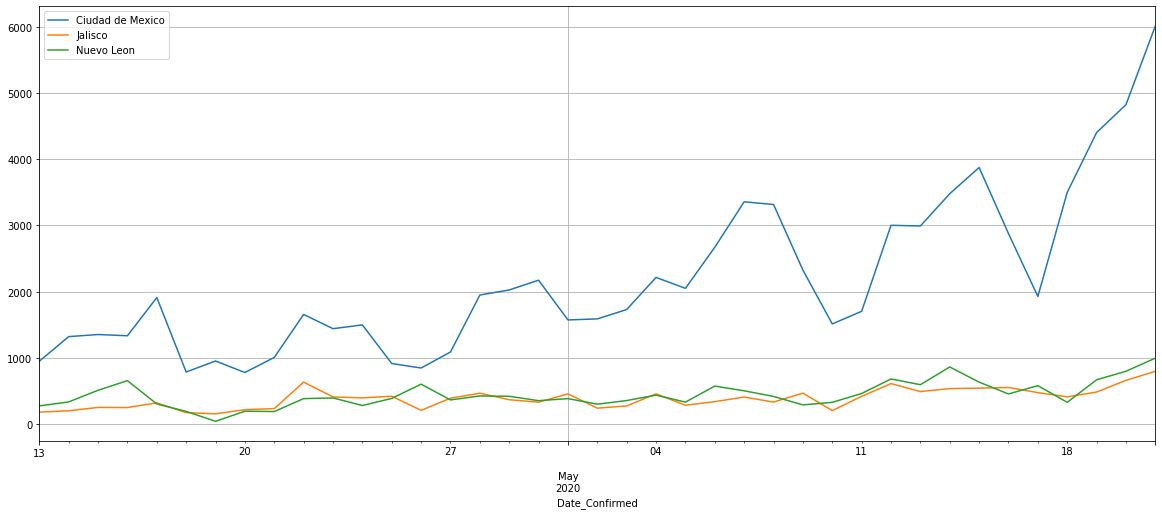

In [78]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_daily[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

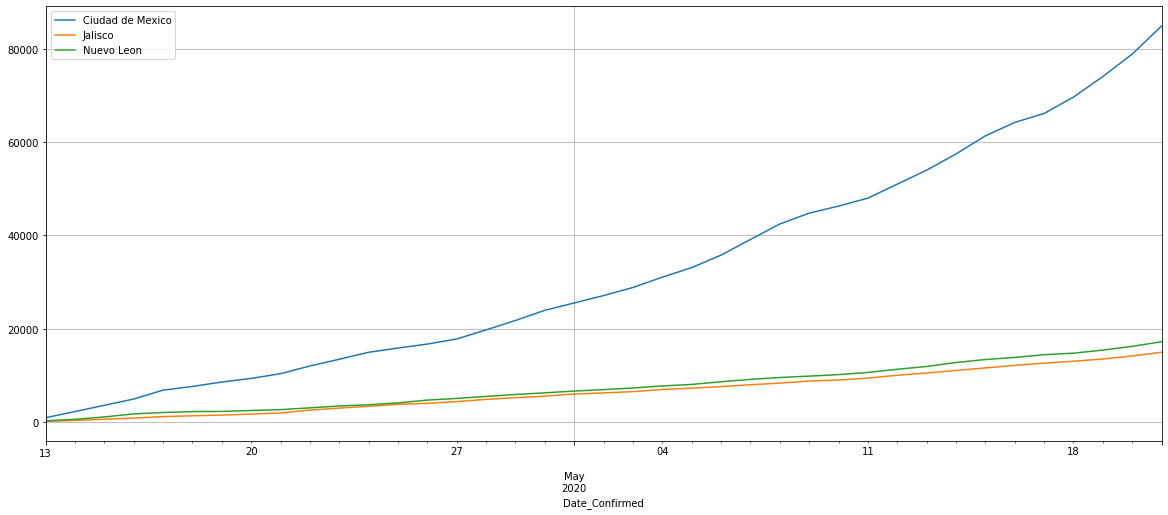

In [79]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_daily[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

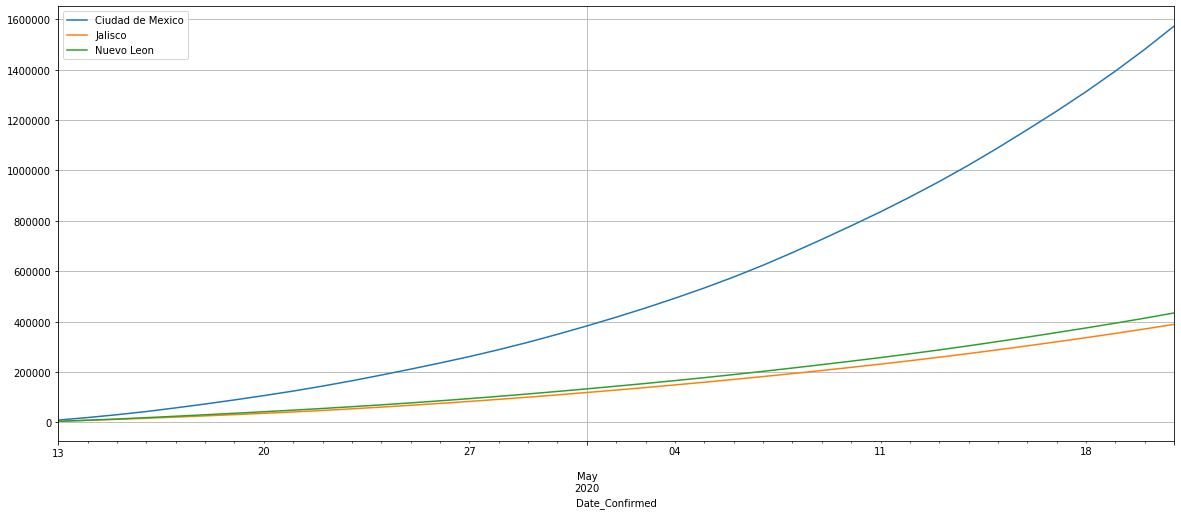

In [80]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_cum[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

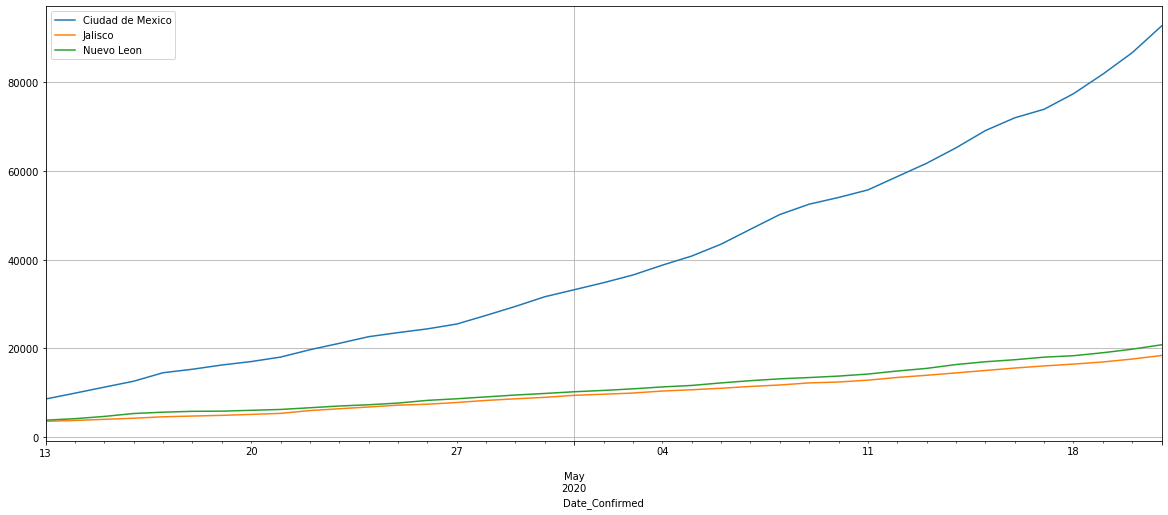

In [81]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    pivot_tbl_cum[state].fillna(0).plot()

plt.legend()
plt.grid(True)
plt.show()

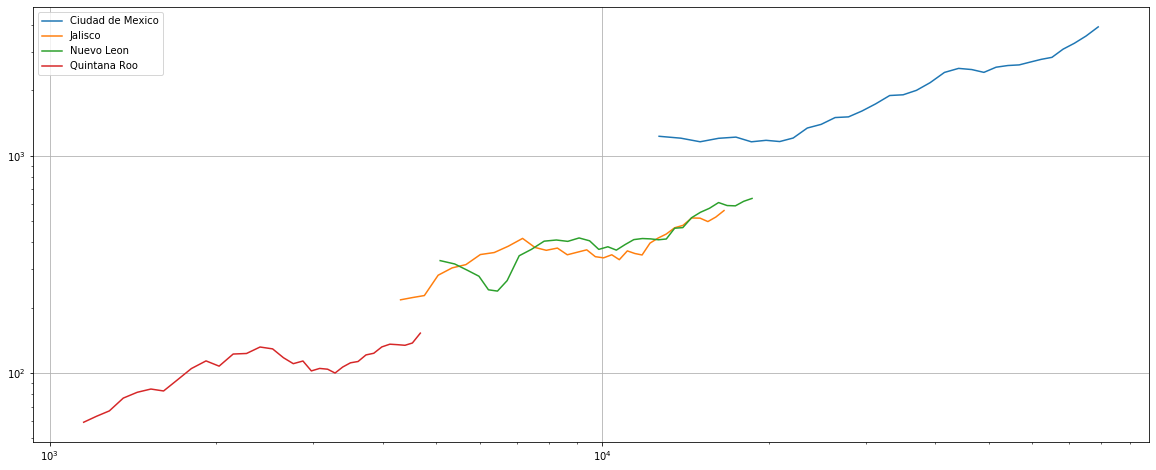

In [82]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon', 'Quintana Roo']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label=state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

In [5]:
cum_df

NameError: name 'cum_df' is not defined

In [6]:
# Needs fix !!!

# Starting at date w/certain number of cases
def select_min_cases(df, min):
    df2_state = []
    df2_dates = []
    df2_cases = []
    for state in df.columns:
        #print(df.columns)
        for index in range(len(df[state])):
            if df[state][index] > min:
                #print(state)
                #print(df[state].index[index])
                #print((df[state][index]))
                df2_state.append(state)
                df2_dates.append(df[state].index[index])
                df2_cases.append(df[state][index])
            #if df[state][index] < num:
                #print(None)
    #my_df = pd.DataFrame({'Region': pd.Series(df2_state), 'Date_Confirmed': pd.Series(df2_dates), 'Region_Cumulative': pd.Series(df2_cases)})
    #my_df = my_df.set_index(['Region','Date_Confirmed'])
    return df2

min_cases = select_min_cases(cum_df, 15).reset_index()
#min_cases = min_cases.drop(['index'], axis=1).reset_index()
#min_cases = min_cases.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.sort_index()
#min_cases = min_cases.fillna(method='ffill')
#daily_min_cases = min_cases.diff()

#plt.figure(figsize=(20,8))

#for state in ['Jalisco', 'Nuevo Leon']:
#    daily_min_cases[state].fillna(0).rolling(window=7).mean().plot()

#plt.legend()
#plt.grid(True)
#plt.show()

NameError: name 'cum_df' is not defined

In [7]:
min_cases

NameError: name 'min_cases' is not defined

In [8]:
min_cases = select_min_cases(cum_df, 15)

NameError: name 'cum_df' is not defined

In [9]:
plt.figure(figsize=(20,8))

for state in ['Ciudad de Mexico', 'Jalisco', 'Nuevo Leon']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label = state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

NameError: name 'plt' is not defined

### Lag in cases reported

In [10]:
import janitor
test = pivot_tbl_daily
abr_19 = test.filter_date('Date_Confirmed','2020-04-13','2020-05-12')

NameError: name 'pivot_tbl_daily' is not defined

In [ ]:
abr_19['Ciudad de Mexico'].plot(kind='bar', title='')